# ML Gdansk (1 VI 2020)

## "Regularizing and distilling knowledge nicely with TensorFlow Datasets" @ https://www.mlgdansk.pl/
#### Krzysztof Czuszyński, Solwit SA

krzysztof.czuszynski@solwit.com  
Materials available at ML Gdansk Github (https://github.com/mlgdansk/meetings) and my Github (https://github.com/chrisqlasty)

--- 

## Agenda:
### 1. Make Teacher models for classification
#### &nbsp;&nbsp;&nbsp; 1.a Plain Teacher Model
#### &nbsp;&nbsp;&nbsp; 1.b Ranking Regularized Teacher Model
### 2. Download and prepare dataset (make TFRecords)
### 3. Train Teacher model w/o and with Ranking Regularizer
### 4. Train independent Student
### 5. Get knowledge from Teacher model and train guided Student (Knowledge Distillation) 

---

#### References:  
[1] _Boosting Standard Classification Architectures Through a Ranking Regularizer_, Ahmed Taha, Yi-Ting Chen, Teruhisa Misu, Abhinav Shrivastava, Larry Davis  
[2] _Distilling the Knowledge in a Neural Network_, Geoffrey Hinton, Oriol Vinyals, Jeff Dean   
[3] _tf.data.Dataset_, TensorFlow  
[4] _https://github.com/EXJUSTICE/GRAB_SEA_CVChallenge_

---
Results in this notebook were from run evaluated with flag _make_long_training_ = True made before.

In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

data_location = "data_location3"
sys.path.insert(0, "/home/jupyter/cache_disk2/MLG1VI2020")
from ds_utils_MLG import *

print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.1.0


In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


In [3]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


## About Ranking Regularizer  

* it is a method for boosting DL classifiers performance
* uses feature embedding loss to regularize
* uses triple loss based loss functions
 * triplet loss is often used in person recognition applications
 * it forces model to produce a set of features from the input base on which some tasks can be performed
 * we use name "triplet" as features are learned based upon similarity of Anchor with Positive image (other instances of same class) and differences between Anchor and Negative image (instances of other classes) - hance triplets of Anchor, Positive, Negative are required

Requires:
* adding extra head to your classification model
* usually modifying your data pipeline to feed two heads with target data
* usually modifying your data pipeline to satisfy triplet-loss constraints  

Original paper uses:
* just single Dense (FC) layer for each head
 * we will do more ops


<br>
<img src="rr_scheme1.png">


### 1. Make Teacher models for classification

In [4]:
TARGET_SIZE = (224,224,3)
N_Classes = 196
SOFTMAX_LAYER = 'softmax_layer'
EMBEDDS_LAYER = 'embeddings_layer'

make_long_training = False

In [5]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, AveragePooling2D, Activation, Lambda, Flatten
from tensorflow.keras.models import Model, load_model

In [6]:
def freeze_up_to_last_conv_layer(baseModel):
    # Finetuning -> freeze pretrained layers
    trainable = True
    for layer in reversed(baseModel.layers):
        if trainable:
            if isinstance(layer, tf.keras.layers.Conv2D):
                trainable = False
                continue
        layer.trainable = trainable
    return baseModel

def freeze_low_layers(baseModel, num_layers=20):
    for layer in baseModel.layers[:num_layers]:
        layer.trainable = False
    return baseModel

def get_model_as_block_and_last_layer(baseModel):                
    block_input = Input(shape=(baseModel.input.get_shape().as_list()[1:]), name='InputToModel')
    block_output = baseModel(block_input)    
    model_block = Model(inputs=block_input, outputs=block_output)
    
    return model_block, block_output

In [7]:
def get_Teacher_model():       
    import tensorflow as tf
    tf.random.set_seed(2020)
    
    baseModel = MobileNetV2(weights='imagenet', include_top=False, input_shape=TARGET_SIZE, 
                            layers=tf.keras.layers)
    baseModel = freeze_low_layers(baseModel)

    SOTA_block, block_output = get_model_as_block_and_last_layer(baseModel)

    headModel = GlobalAveragePooling2D()(SOTA_block.output)            
    headModel = Dense(1024, activation='relu')(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(N_Classes)(headModel)
    headModel = Activation('softmax', name=SOFTMAX_LAYER)(headModel)
    
    '''
    # model as in paper
    headModel = AveragePooling2D()(SOTA_block.output)            
    headModel = Flatten())(headModel)    
    headModel = Dense(N_Classes)(headModel)
    headModel = Activation('softmax', name=SOFTMAX_LAYER)(headModel)
    '''
    
    plainTeacherModel = Model(inputs=SOTA_block.input, outputs=headModel)    

    return plainTeacherModel, block_output

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

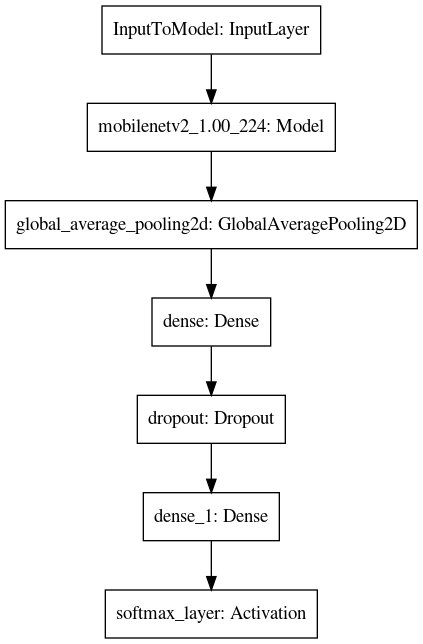

In [8]:
with strategy.scope():
    plainTeacherModel, _ = get_Teacher_model()
    print(plainTeacherModel.summary())
tf.keras.utils.plot_model(plainTeacherModel)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputToModel (InputLayer)       [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Model)    (None, 7, 7, 1280)   2257984     InputToModel[0][0]               
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1280)         0           mobilenetv2_1.00_224[1][0]       
__________________________________________________________________________________________________
flatten (Flatten)               (None, 62720)        0           mobilenetv2_1.00_224[1][0]       
____________________________________________________________________________________________

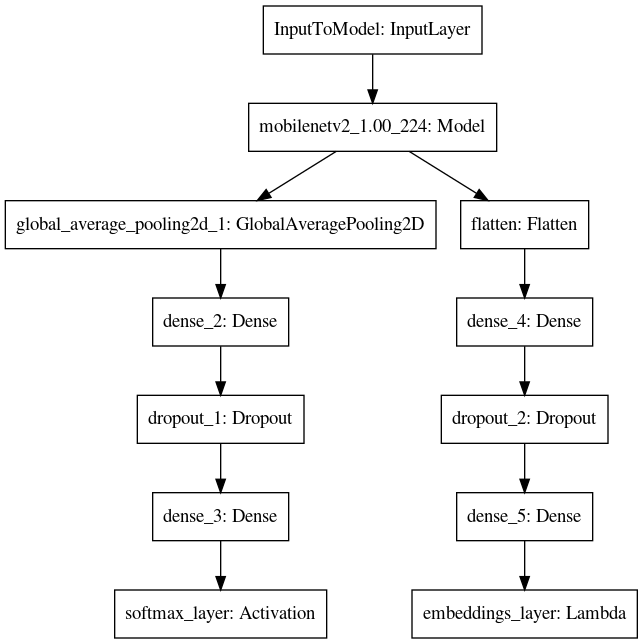

In [9]:
def get_Teacher_model_with_RR():    
    import tensorflow as tf
    tf.random.set_seed(2020)
    plainTeacherModel, block_output = get_Teacher_model()

    embeddings = Flatten()(block_output)    
    embeddings = Dense(32, activation='relu')(embeddings) # remove to get model as in paper
    embeddings = Dropout(0.5)(embeddings) # remove to get model as in paper
    embeddings = Dense(256)(embeddings)
    output_embeded = Lambda(lambda feature: tf.math.l2_normalize(feature, axis=1), name=EMBEDDS_LAYER)(embeddings) # L2 normalize embeddings

    RRTeacherModel = Model(inputs=plainTeacherModel.input, outputs=[plainTeacherModel.output, output_embeded])
    
    return RRTeacherModel
    
with strategy.scope():    
    RRTeacherModel = get_Teacher_model_with_RR()
    print(RRTeacherModel.summary())    
tf.keras.utils.plot_model(RRTeacherModel)

### 2. Download and prepare dataset (make TFRecords)

In [10]:
(ds_train, ds_valid, ds_test), ds_info = tfds.load(
    'cars196',    
    split=['train', 'test[50%:]', 'test[:50%]'],    
    as_supervised=True,
    with_info=True)

In [11]:
ds_info

tfds.core.DatasetInfo(
    name='cars196',
    version=2.0.0,
    description='The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.',
    homepage='https://ai.stanford.edu/~jkrause/cars/car_dataset.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
    }),
    total_num_examples=16185,
    splits={
        'test': 8041,
        'train': 8144,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{KrauseStarkDengFei-Fei_3DRR2013,
      title = {3D Object Representations for Fine-Grained Categorization},
      booktitle = {4th International IEEE Worksh

See what we got:

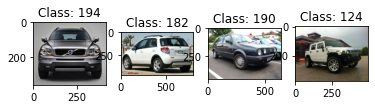

In [12]:
display_images_and_labels_from_dataset(dataset=ds_train)

In [13]:
def get_filtered_resized_dataset(dataset, filter_label_value):
    dataset = dataset.filter(lambda image, label: tf.equal(label, filter_label_value))
    return dataset.map(lambda image, label: (tf.cast(tf.image.resize(image, TARGET_SIZE[:-1]),tf.uint8), label))    

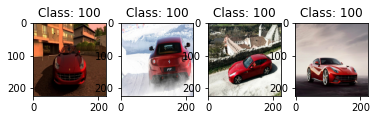

In [14]:
some_filtered_ds = get_filtered_resized_dataset(dataset=ds_train, filter_label_value=100)
display_images_and_labels_from_dataset(some_filtered_ds)

Cell below ([15]) can be used to generate separate TFRecords images of each class. Produce them using data_producer.ipynb.

In [15]:
from tqdm.notebook import tqdm as ntqdm

def produce_TFRs_from_filtered_datasets(dataset, subset):
    for idx in ntqdm( range(N_Classes) ):
        some_filtered_dataset = get_filtered_resized_dataset(dataset,filter_label_value=idx)
        dataset_to_TFR(some_filtered_dataset, prefix_target_filename=f'{subset}_{idx}', features_keys=['img','label'])
        print(f'TFR for class {idx} finished!')

In [16]:
def decode_from_TFR_example(serialized_example):
    
    features = tf.io.parse_single_example(
        serialized_example,
        features={
            'img': tf.io.FixedLenFeature([], tf.string),    
            'label': tf.io.FixedLenFeature([], tf.int64),
        })

    image = tf.io.decode_raw(features['img'], tf.uint8)  
    image = tf.cast(tf.reshape(image, TARGET_SIZE), tf.float32)    
    image = preprocess_input(image)        
    
    label = features['label']                
    
    return image, label

In [17]:
def augument_image(image):    
    image = tf.image.random_hue(image, 0.2)
    image = tf.image.random_saturation(image, 0.8, 1.4)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    image = tf.image.random_flip_left_right(image)
    return image

In [18]:
def produceFilePaths(f):
    def wrapper(**kwargs):                
        fileNames = sorted(list(filter(lambda x: x.startswith(kwargs['prefix']), os.listdir(data_location))))
        kwargs['filePaths'] = [f"{data_location}/{fileName}" for fileName in fileNames]        
        return f(**kwargs)
    return wrapper

In [19]:
@produceFilePaths
def base_dataset_from_TFRs(**kwargs):

    dataset = tf.data.Dataset.from_tensor_slices(kwargs['filePaths'])  
    
    if kwargs['shuffle']:
        dataset = dataset.shuffle(len(kwargs['filePaths']), reshuffle_each_iteration=True)
    
    dataset = dataset.interleave(lambda filePath: tf.data.TFRecordDataset(filePath),
                                    num_parallel_calls=tf.data.experimental.AUTOTUNE,
                                    cycle_length=len(kwargs['filePaths']),
                                    block_length=kwargs['block_length'])

    dataset = dataset.map(decode_from_TFR_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)              
    
    if kwargs['shuffle']:
        dataset = dataset.map(lambda image, label: (augument_image(image), label), 
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if kwargs['one_hot']:
        dataset = dataset.map(lambda image, label: (image, tf.keras.backend.one_hot(label, num_classes=N_Classes)), 
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
        
    if kwargs['block_length']>1:
        dataset = dataset.batch(kwargs['block_length'])
                           
    if kwargs['shuffle']:    
        dataset = dataset.shuffle(4096, reshuffle_each_iteration=True)            
    else:
        name = kwargs['prefix']
        dataset = dataset.cache(f'cacher_{name}')
        
    if kwargs['block_length']>1:
        dataset = dataset.unbatch()    
        
    return dataset.batch(kwargs['minibatch'])

In [20]:
toy_ds = base_dataset_from_TFRs(prefix='train_L', minibatch = 32, shuffle=False, block_length=1, one_hot=False)

for images, labels in toy_ds.take(1):
    pass
    
print(labels)    

tf.Tensor(
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31], shape=(32,), dtype=int64)


In [21]:
toy_ds = base_dataset_from_TFRs(prefix='train_L', minibatch = 32, shuffle=False, block_length=2, one_hot=False)

for images, labels in toy_ds.take(1):
    pass
    
print(labels)    

tf.Tensor(
[ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11
 12 12 13 13 14 14 15 15], shape=(32,), dtype=int64)


We group examples by 2 as Triplet Loss needs to have Anchors and Positive pairs.

In [22]:
toy_ds = base_dataset_from_TFRs(prefix='train_L', minibatch = 32, shuffle=True, block_length=2, one_hot=False)

for images, labels in toy_ds.take(1):
    pass
    
print(labels)    

tf.Tensor(
[186 186 185 185  97  97 143  63  51  51  85  85 153  53 127 127  15 164
  75  75 152 152  90  90 159 159 119 160 174 174  19  19], shape=(32,), dtype=int64)


In [23]:
MINIBATCH = 32*len(gpu_devices)
ds_tr = base_dataset_from_TFRs(prefix='train_L', minibatch=MINIBATCH, shuffle=True, block_length=2, one_hot=True)
ds_va = base_dataset_from_TFRs(prefix='valid_L', minibatch=MINIBATCH, shuffle=False, block_length=2, one_hot=True)
ds_te = base_dataset_from_TFRs(prefix='test_L', minibatch=MINIBATCH, shuffle=False, block_length=2, one_hot=True)

### 3. Train Teacher model w/o and with Ranking Regularizer

In [24]:
with strategy.scope():   
    plainTeacherModel, _ = get_Teacher_model()
    plainTeacherModel.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5),
                              loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

hist = plainTeacherModel.fit(ds_tr.prefetch(1), validation_data=ds_va.prefetch(1), epochs=2)

Epoch 1/2
INFO:tensorflow:batch_all_reduce: 141 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 141 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 141 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 141 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


64/64 [==============================] - 59s 923ms/step - loss: 5.5372 - accuracy: 0.0060 - val_loss: 5.3377 - val_accuracy: 0.0085
Epoch 2/2
64/64 [==============================] - 16s 250ms/step - loss: 5.3278 - accuracy: 0.0092 - val_loss: 5.2824 - val_accuracy: 0.0109


### Training regular Teachers

In [25]:
EPOCHS = 500
TRIALS = 1

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm.keras import TqdmCallback

if make_long_training:

    va_score = []
    te_score = []

    for idx in range(TRIALS):
        model_name = f'{data_location}/plainTeacherModel_{idx}.h5'

        K.clear_session()
        with strategy.scope():
            plainTeacherModel, _ = get_Teacher_model()
            plainTeacherModel.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), 
                                      loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
        hist_plain_teacher = plainTeacherModel.fit(ds_tr.prefetch(1), 
                                     validation_data=ds_va.prefetch(1),
                                     verbose=0,
                                     epochs=EPOCHS,
                                     callbacks=[TqdmCallback(verbose=1),
                                                ModelCheckpoint(model_name, monitor='val_accuracy', verbose=0, 
                                                      save_best_only=True, save_weights_only=False, mode='max'),
                                                EarlyStopping(monitor='val_accuracy', patience=20, verbose=0, mode='max')])

        plainTeacherModel.load_weights(model_name)

        va_score.append(plainTeacherModel.evaluate(ds_va)[1]*100)
        te_score.append(plainTeacherModel.evaluate(ds_te)[1]*100)

    my_saver(_list=va_score, _fname='Plain_Teacher_valid.npy')    
    my_saver(_list=te_score, _fname='Plain_Teacher_test.npy')

Using TensorFlow backend.


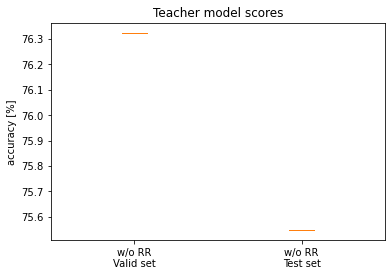

In [27]:
plain_teacher_valid_scores = my_reader(_fname='Plain_Teacher_valid.npy')
plain_teacher_test_scores = my_reader(_fname='Plain_Teacher_test.npy')

title = 'w/o RR'
plot1 = plt.boxplot([plain_teacher_valid_scores, plain_teacher_test_scores])
plot1 = plt.xticks([1,2], labels=[f'{title}\nValid set',f'{title}\nTest set'])
plot1 = plt.ylabel('accuracy [%]')
plot1 = plt.title('Teacher model scores')

## Training Teachers with Rank Regularizers

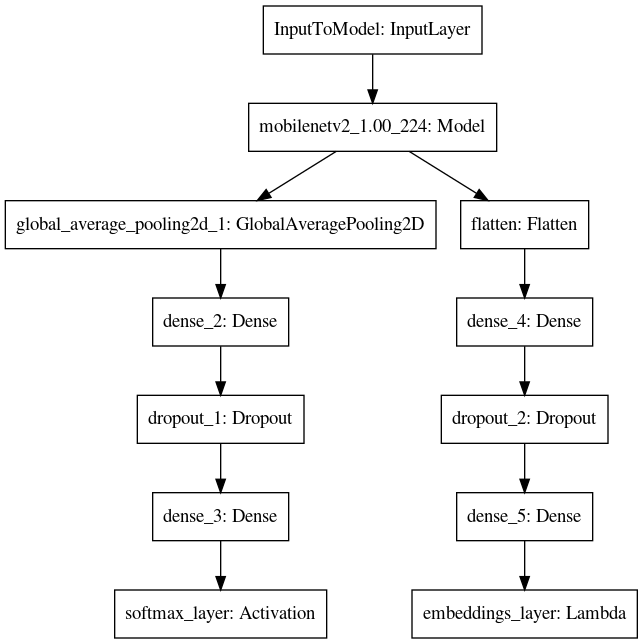

In [28]:
tf.keras.utils.plot_model(RRTeacherModel)

In [29]:
import tensorflow_addons as tfa

losses = {
    SOFTMAX_LAYER: tf.keras.losses.categorical_crossentropy,
    EMBEDDS_LAYER: tfa.losses.TripletSemiHardLoss(margin=0.2)
}

lambda_rr = 1.0

loss_weights = {
    SOFTMAX_LAYER: 1.0,
    EMBEDDS_LAYER: 1.0*lambda_rr,
}

In [30]:
with strategy.scope():
    RRTeacherModel.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5),
                           loss=losses,
                           loss_weights=loss_weights,
                           metrics=['accuracy'])

In [31]:
ds_tr_trip = ds_tr.map(lambda im, lab: (im, (lab, tf.argmax(lab,axis=1))), 
                       num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(1)
ds_va_trip = ds_va.map(lambda im, lab: (im, (lab, tf.argmax(lab,axis=1))), 
                       num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(1)
ds_te_trip = ds_te.map(lambda im, lab: (im, (lab, tf.argmax(lab,axis=1))), 
                       num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(1)

hist = RRTeacherModel.fit(ds_tr_trip, validation_data=ds_va_trip, epochs=2)

Epoch 1/2


INFO:tensorflow:batch_all_reduce: 145 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 145 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 145 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 145 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


64/64 [==============================] - 57s 886ms/step - loss: 6.1841 - softmax_layer_loss: 5.5642 - embeddings_layer_loss: 0.1550 - softmax_layer_accuracy: 0.0052 - embeddings_layer_accuracy: 0.0011 - val_loss: 6.0151 - val_softmax_layer_loss: 5.3395 - val_embeddings_layer_loss: 0.1689 - val_softmax_layer_accuracy: 0.0080 - val_embeddings_layer_accuracy: 0.0000e+00
Epoch 2/2
64/64 [==============================] - 20s 312ms/step - loss: 6.0334 - softmax_layer_loss: 5.4290 - embeddings_layer_loss: 0.1511 - softmax_layer_accuracy: 0.0086 - embeddings_layer_accuracy: 6.1395e-04 - val_loss: 5.9591 - val_softmax_layer_loss: 5.2951 - val_embeddings_layer_loss: 0.1660 - val_softmax_layer_accuracy: 0.0109 - val_embeddings_layer_accuracy: 0.0000e+00


In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm.keras import TqdmCallback

if make_long_training:

    va_score = []
    te_score = []

    for idx in range(TRIALS):
        model_name = f'{data_location}/RRTeacherModel_{idx}.h5'

        K.clear_session()
        with strategy.scope():
            RRTeacherModel = get_Teacher_model_with_RR()    
            RRTeacherModel.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5),
                                   loss=losses,
                                   loss_weights=loss_weights,
                                   metrics=['accuracy'])        

        hist_RR_teacher = RRTeacherModel.fit(ds_tr_trip, 
                                  validation_data=ds_va_trip,
                                  verbose=0,
                                  epochs=EPOCHS,
                                  callbacks=[TqdmCallback(verbose=1),
                                             ModelCheckpoint(
                                                model_name, monitor=f'val_{SOFTMAX_LAYER}_accuracy', verbose=0, 
                                                save_best_only=True, save_weights_only=True, mode='max'),
                                             EarlyStopping(monitor=f'val_{SOFTMAX_LAYER}_accuracy', patience=20, verbose=0, mode='max')])

        RRTeacherModel.load_weights(model_name)

        va_score.append(RRTeacherModel.evaluate(ds_va_trip)[3]*100)
        te_score.append(RRTeacherModel.evaluate(ds_te_trip)[3]*100)


    my_saver(_list=va_score, _fname='RR_Teacher_valid.npy')    
    my_saver(_list=te_score, _fname='RR_Teacher_test.npy')        

In [33]:
RR_teacher_valid_scores = my_reader(_fname='RR_Teacher_valid.npy')
RR_teacher_test_scores = my_reader(_fname='RR_Teacher_test.npy')

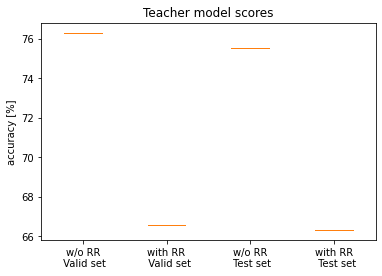

In [34]:
title2 = 'with RR'
plot2 = plt.boxplot([plain_teacher_valid_scores, 
                     RR_teacher_valid_scores,                     
                     plain_teacher_test_scores,
                     RR_teacher_test_scores, ])
plot2 = plt.xticks([1,2,3,4], labels=[f'{title}\n Valid set',
                                      f'{title2}\n  Valid set',
                                      f'{title}\n Test set',
                                      f'{title2}\n  Test set'])
plot2 = plt.ylabel('accuracy [%]')
plot2 = plt.title('Teacher model scores')

In [35]:
if make_long_training:

    my_saver(_list=hist_plain_teacher.history['accuracy'], _fname='plain_Teacher_train_epochs.npy')    
    my_saver(_list=hist_plain_teacher.history['val_accuracy'], _fname='plain_Teacher_valid_epochs.npy')  

    my_saver(_list=hist_RR_teacher.history[f'{SOFTMAX_LAYER}_accuracy'], _fname='RR_Teacher_train_epochs.npy')    
    my_saver(_list=hist_RR_teacher.history[f'val_{SOFTMAX_LAYER}_accuracy'], _fname='RR_Teacher_valid_epochs.npy')  

In [36]:
plain_Teacher_train_epochs = my_reader(_fname='plain_Teacher_train_epochs.npy')
plain_Teacher_valid_epochs = my_reader(_fname='plain_Teacher_valid_epochs.npy')

RR_Teacher_train_epochs = my_reader(_fname='RR_Teacher_train_epochs.npy')
RR_Teacher_valid_epochs = my_reader(_fname='RR_Teacher_valid_epochs.npy')

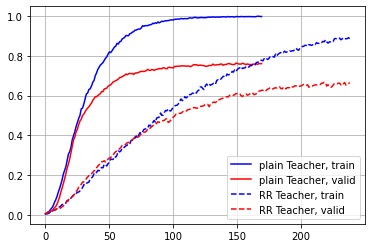

In [37]:
plt.plot(plain_Teacher_train_epochs, '-', color='blue', label='plain Teacher, train')
plt.plot(plain_Teacher_valid_epochs, '-', color='red', label='plain Teacher, valid')

plt.plot(RR_Teacher_train_epochs, '--', color='blue', label='RR Teacher, train')
plt.plot(RR_Teacher_valid_epochs, '--', color='red', label='RR Teacher, valid')

plt.legend()
plt.grid()

### 4. Train independent Student

In [38]:
SOFTMAX_1_LAYER = 'softmax_1_layer'
SOFTMAX_2_LAYER = 'softmax_2_layer'

In [39]:
def get_base_Student_model():      
    import tensorflow as tf
    tf.random.set_seed(2020)
    baseModel = MobileNetV2(weights='imagenet', include_top=False, input_shape=TARGET_SIZE, 
                            layers=tf.keras.layers, alpha=0.35)
    baseModel = freeze_low_layers(baseModel)

    headModel = GlobalAveragePooling2D()(baseModel.output)            
    headModel = Dense(1024, activation='relu')(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(N_Classes)(headModel)
    
    baseModel = Model(inputs=baseModel.input, outputs=headModel)  
    
    return baseModel

In [40]:
def get_Student_model():        
    baseModel = get_base_Student_model()
    model_block, block_output = get_model_as_block_and_last_layer(baseModel)
            
    headModel = Activation('softmax', name=SOFTMAX_1_LAYER)(model_block.output)
    
    plainStudentModel = Model(inputs=model_block.input, outputs=[headModel])    
        
    return plainStudentModel, block_output

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputToModel (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
model_7 (Model)              (None, 196)               1922852   
_________________________________________________________________
softmax_1_layer (Activation) (None, 196)               0         
Total params: 1,922,852
Trainable params: 1,906,196
Non-trainable params: 16,656
_________________________________________________________________
None


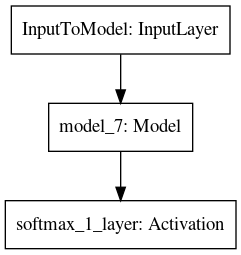

In [41]:
with strategy.scope():
    plainStudentModel, _ = get_Student_model()
    print(plainStudentModel.summary())
tf.keras.utils.plot_model(plainStudentModel)

In [42]:
with strategy.scope():
    plainStudentModel.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
    
plainStudentModel.fit(ds_tr.prefetch(1), validation_data=ds_va.prefetch(1), epochs=2)

Epoch 1/2
INFO:tensorflow:batch_all_reduce: 141 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 141 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 141 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 141 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


64/64 [==============================] - 47s 742ms/step - loss: 5.5231 - accuracy: 0.0071 - val_loss: 5.3531 - val_accuracy: 0.0067
Epoch 2/2
64/64 [==============================] - 13s 196ms/step - loss: 5.4012 - accuracy: 0.0075 - val_loss: 5.3031 - val_accuracy: 0.0067


In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.keras import TqdmCallback

if make_long_training:

    va_score = []
    te_score = []

    for idx in range(TRIALS):
        model_name = f'{data_location}/plainStudentModel_{idx}.h5'

        K.clear_session()
        with strategy.scope():
            plainStudentModel, _ = get_Student_model()
            plainStudentModel.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
        hist_plain_student = plainStudentModel.fit(ds_tr.prefetch(1), 
                                     validation_data=ds_va.prefetch(1),
                                     verbose=0,
                                     epochs=EPOCHS,
                                     callbacks=[TqdmCallback(verbose=1),
                                                ModelCheckpoint(model_name, monitor='val_accuracy', verbose=0, 
                                                      save_best_only=True, save_weights_only=False, mode='max'),
                                                EarlyStopping(monitor='val_accuracy', patience=20, verbose=0, mode='max')])

        plainStudentModel.load_weights(model_name)

        va_score.append(plainStudentModel.evaluate(ds_va)[1]*100)
        te_score.append(plainStudentModel.evaluate(ds_te)[1]*100)

    my_saver(_list=va_score, _fname='Plain_Student_valid.npy')    
    my_saver(_list=te_score, _fname='Plain_Student_test.npy')

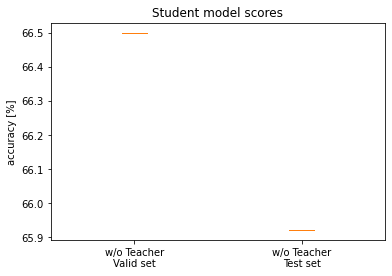

In [44]:
plain_student_valid_scores = my_reader(_fname='Plain_Student_valid.npy')
plain_student_test_scores = my_reader(_fname='Plain_Student_test.npy')

title = 'w/o Teacher'
plot1 = plt.boxplot([plain_student_valid_scores, plain_student_test_scores])
plot1 = plt.xticks([1,2], labels=[f'{title}\nValid set',f'{title}\nTest set'])
plot1 = plt.ylabel('accuracy [%]')
plot1 = plt.title('Student model scores')

## About Knowledge Distillation

#### Knowledge distillation helps training smaller Student models based on knowledge of bigger Teachers
* It relies on adjusting temperature of Teacher model outputs
* Trained teacher predicts output vector that contains more information than one-hot-label
* However, often the Teacher if very certain about prediction but there is also some hidden dark knowledge it has gained during training
* Eg: Teacher has predicted that there is a cat on the image with 99.9% confidence, dog with 0.008%, car with 0.002%
 * application of higher Temperature T to this output (before softmax) lowers big confidence score and increases others
 * labels scaled with some temperature are called "soft-labels"
 * now we can see that model "thinks" that cat is more like a dog than a car
 * smaller Student model, given that knowledge aparat of regular one-hot labels should be trained quicker and better

For classification it requires:
* Teacher model with logits but not softmax activation
* Data generator or pipeline that tunes Teacher output to different temperatures
* Student network with two heads: for one-hot-labels and for soft labels

<img src="KD1.png">


### 5. Get knowledge from Teacher model and train guided Student (Knowledge Distillation) 

Our RR Teacher was not better than plain Teacher hence we selected the last one for guiding Student.

In [45]:
top_model_name = ''
top_score = -1
for idx in range(TRIALS):
    model_name = f'{data_location}/plainTeacherModel_{idx}.h5'
    plainTeacherModel.load_weights(model_name)
    tmp_model = Model(plainTeacherModel.input, plainTeacherModel.get_layer(SOFTMAX_LAYER).output)
    tmp_model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
    
    s = tmp_model.evaluate(ds_va, verbose=0)
    if s[1]>top_score:
        top_model_name = model_name
        top_score = s[1]
print(f'Best model: {top_model_name} with validation score: {top_score}')

Best model: data_location3/plainTeacherModel_0.h5 with validation score: 0.7632429599761963


In [46]:
plainTeacherModel.load_weights(top_model_name)
plainTeacherModel.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [47]:
plainTeacherModel.evaluate(ds_va)

     32/Unknown - 7s 233ms/step - loss: 0.9199 - accuracy: 0.7632

[0.9199024196714163, 0.76324296]

In [48]:
teacher_model_bold = Model(plainTeacherModel.input, plainTeacherModel.get_layer(SOFTMAX_LAYER).input)
teacher_model_bold.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
teacher_model_bold.trainable = False

In [49]:
teacher_model_bold.evaluate(ds_va) 

     32/Unknown - 5s 171ms/step - loss: 15.9171 - accuracy: 0.7632

[15.917102366685867, 0.76324296]

In [50]:
with tf.device('/device:GPU:0'):
    teacher_model_bold.evaluate(ds_va)

     32/Unknown - 5s 157ms/step - loss: 15.9171 - accuracy: 0.7632

In [51]:
def get_targets_for_both_heads(images, labels, T=1.0):       
    with tf.device('/device:GPU:0'): 
        logits = teacher_model_bold(images)
        
    temp_l = K.softmax(logits/T)    
    return (labels, temp_l)    

In [52]:
@tf.function
def get_data_and_preds_dataset(data_dataset, T=1.):                        
    data_and_preds_dataset = data_dataset.map(lambda image, label: 
                                              (image, get_targets_for_both_heads(image, label, T=T)),
                                               num_parallel_calls=tf.data.experimental.AUTOTUNE)    
    return data_and_preds_dataset

In [53]:
with tf.device('/CPU:0'):
    ds_for_simple_test = get_data_and_preds_dataset(ds_te, T=1)  

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/autograph/impl/api.py:330: UserWarning: Seed 2020 from outer graph might be getting used by function Dataset_map_lambda, if the random op has not been provided any seed. Explicitly set the seed in the function if this is not the intended behavior.
  return f(*args, **kwargs)


Temp 1 sum: 0.9999998807907104, argmax: 1
Temp 3 sum: 1.0, argmax: 1
Temp 10 sum: 1.0, argmax: 1


Text(0.5, 0, 'Temperature')

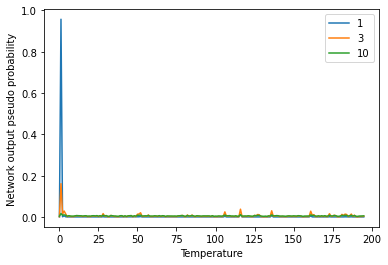

In [54]:
# Gets errors with TF2.2
temps_list = [1, 3, 10]

outputs = []
for T in temps_list:    
    with tf.device('/CPU:0'):
        ds_for_simple_test = get_data_and_preds_dataset(ds_te, T=T)    
    for images, targets in ds_for_simple_test.take(1):
        pass    
    outputs.append(targets[1][3,:].numpy())

for T, output in zip(temps_list, outputs):
    plt.plot(output, label=T)    
    print('Temp {} sum: {}, argmax: {}'.format(T, output.sum(), output.argmax()))
plt.legend()
plt.ylabel('Network output pseudo probability')
plt.xlabel('Temperature')

Text(0.5, 0, 'Temperature')

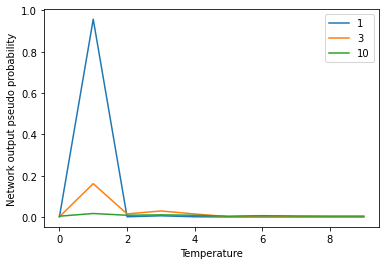

In [55]:
for T, output in zip(temps_list, outputs):
    plt.plot(output[0:10], label=T)
plt.legend()
plt.ylabel('Network output pseudo probability')
plt.xlabel('Temperature')

Text(0.5, 0, 'Temperature')

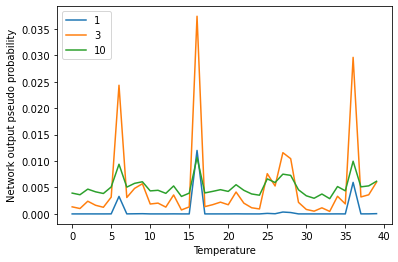

In [56]:
for T, output in zip(temps_list, outputs):
    plt.plot(output[100:140], label=T)
plt.legend()
plt.ylabel('Network output pseudo probability')
plt.xlabel('Temperature')

In [57]:
strategy_of_3 = tf.distribute.MirroredStrategy(['GPU:1','GPU:2','GPU:3'])    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputToModel (InputLayer)       [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_12 (Model)                (None, 196)          1922852     InputToModel[0][0]               
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 196)          0           model_12[1][0]                   
__________________________________________________________________________________________________
softmax_1_layer (Activation)    (None, 196)          0           model_12[1][0]                   
___________________________________________________________________________________________

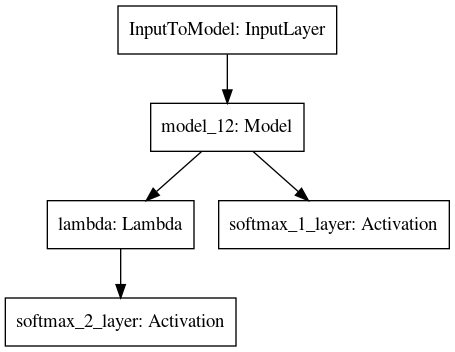

In [58]:
def get_Student_with_Guide(T=1.):
    plainStudentModel, block_output = get_Student_model()

    logits_T = Lambda(lambda logits: logits/T)(block_output)
    probabilities_T = Activation('softmax', name=SOFTMAX_2_LAYER)(logits_T)
    
    guidedStudentModel = Model(inputs=plainStudentModel.input, 
                               outputs=[plainStudentModel.output, probabilities_T])
    return guidedStudentModel
    
with strategy_of_3.scope():
    guidedStudentModel = get_Student_with_Guide(T=2)  
    print(guidedStudentModel.summary())
tf.keras.utils.plot_model(guidedStudentModel)

In [59]:
import tensorflow_addons as tfa

losses = {
    SOFTMAX_1_LAYER: tf.keras.losses.categorical_crossentropy,
    SOFTMAX_2_LAYER: tf.keras.losses.categorical_crossentropy,
}

lambda_kd = 1.0

loss_weights = {
    SOFTMAX_1_LAYER: 1.0,
    SOFTMAX_2_LAYER: 1.0*lambda_kd,
}

with strategy_of_3.scope():
    guidedStudentModel.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5),
              loss=losses,
              loss_weights=loss_weights,
              metrics=['accuracy'])

In [60]:
with tf.device('/CPU:0'):
    ds_tr_guide = get_data_and_preds_dataset(ds_tr, T=2).prefetch(1)
    ds_va_guide = get_data_and_preds_dataset(ds_va, T=2).prefetch(1)

guidedStudentModel.fit(ds_tr_guide, validation_data=ds_va_guide, epochs=2)

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/autograph/impl/api.py:330: UserWarning: Seed 2020 from outer graph might be getting used by function Dataset_map_lambda, if the random op has not been provided any seed. Explicitly set the seed in the function if this is not the intended behavior.
  return f(*args, **kwargs)


Epoch 1/2
INFO:tensorflow:batch_all_reduce: 141 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 141 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 141 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 141 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


64/64 [==============================] - 53s 833ms/step - loss: 10.8557 - softmax_1_layer_loss: 5.5215 - softmax_2_layer_loss: 5.3342 - softmax_1_layer_accuracy: 0.0053 - softmax_2_layer_accuracy: 0.0053 - val_loss: 10.6536 - val_softmax_1_layer_loss: 5.3576 - val_softmax_2_layer_loss: 5.2960 - val_softmax_1_layer_accuracy: 0.0077 - val_softmax_2_layer_accuracy: 0.0060
Epoch 2/2
64/64 [==============================] - 24s 381ms/step - loss: 10.6892 - softmax_1_layer_loss: 5.3983 - softmax_2_layer_loss: 5.2908 - softmax_1_layer_accuracy: 0.0060 - softmax_2_layer_accuracy: 0.0060 - val_loss: 10.5857 - val_softmax_1_layer_loss: 5.3059 - val_softmax_2_layer_loss: 5.2799 - val_softmax_1_layer_accuracy: 0.0102 - val_softmax_2_layer_accuracy: 0.0104


In [61]:
temperatures = list(range(2,5))

In [62]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm.keras import TqdmCallback

if make_long_training:

    va_score = []
    te_score = []

    for temperature in temperatures:    
        model_name = f'{data_location}/guidedStudentModel_T{temperature}.h5'    

        K.clear_session()
        with strategy_of_3.scope():
            guidedStudentModel = get_Student_with_Guide(T=temperature)
            guidedStudentModel.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), loss=losses, loss_weights=loss_weights, metrics=['accuracy'])

        with tf.device('/CPU:0'):
            ds_tr_guide = get_data_and_preds_dataset(ds_tr, T=temperature)
            ds_va_guide = get_data_and_preds_dataset(ds_va, T=temperature)
            ds_te_guide = get_data_and_preds_dataset(ds_te, T=temperature)

        hist = guidedStudentModel.fit(ds_tr_guide.prefetch(1), 
                                     validation_data=ds_va_guide.prefetch(1),
                                     verbose=0,
                                     epochs=EPOCHS,
                                     callbacks=[TqdmCallback(verbose=1),
                                                ModelCheckpoint(model_name, monitor=f'val_{SOFTMAX_1_LAYER}_accuracy', verbose=0, 
                                                      save_best_only=True, save_weights_only=False, mode='max'),
                                                EarlyStopping(monitor=f'val_{SOFTMAX_1_LAYER}_accuracy', patience=20, verbose=0, mode='max')])

        guidedStudentModel.load_weights(model_name)

        va_score.append(guidedStudentModel.evaluate(ds_va_guide)[3]*100)
        te_score.append(guidedStudentModel.evaluate(ds_te_guide)[3]*100)

    my_saver(_list=va_score, _fname='Guided_Student_valid.npy')
    my_saver(_list=te_score, _fname='Guided_Student_test.npy')

In [63]:
guided_student_valid_scores = my_reader(_fname='Guided_Student_valid.npy')
guided_student_test_scores = my_reader(_fname='Guided_Student_test.npy')

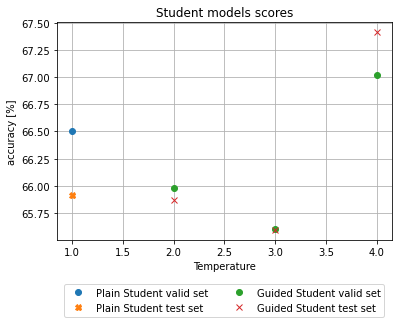

In [64]:
mean_temp1_valid = np.mean(plain_student_valid_scores)
mean_temp1_test = np.mean(plain_student_test_scores)

plt.plot([1], [mean_temp1_valid], 'o', label='Plain Student valid set')
plt.plot([1], [mean_temp1_test], 'X', label='Plain Student test set')
plt.plot(temperatures, guided_student_valid_scores, 'o', label='Guided Student valid set')
plt.plot(temperatures, guided_student_test_scores, 'x', label='Guided Student test set')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=2)
plt.title('Student models scores')
plt.xlabel('Temperature')
plt.ylabel('accuracy [%]')
plt.grid()